# StroopActFlow
### Identify stimuli localizers for input layer for Stroop Model
### Identify top-down task rule inputs (e.g., PFC) for Stroop Model
### First use MVPA to identify ROIs for each stimulus type; then use GLM to find activation patterns
### Using new GLM with rule and trial beta series model


#### Taku Ito
#### 02/22/17


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as stats
import statsmodels.sandbox.stats.multicomp as mc
import os
import nibabel as nib
from sklearn.svm import SVC
import utils

In [2]:
def convertCSVToCIFTI64k(inputfilename,outputfilename):
    ciftitemplate = '/projects3/StroopActFlow/data/Q1-Q6_RelatedParcellation210.LR.CorticalAreas_dil_Colors.32k_fs_LR.dlabel.nii'
    wb_command = 'wb_command -cifti-convert -from-text' 
    wb_command += ' ' + inputfilename 
    wb_command += ' ' + ciftitemplate
    wb_command += ' ' + outputfilename
    wb_command += " -col-delim ','"
    wb_command += ' -reset-scalars'
    os.system(wb_command)
#     print wb_command

## 0.0 Set up

In [3]:
subjNums = ['101', '102']

basedir = '/projects3/StroopActFlow/data/'
resultsdir = basedir + 'results/'
restdir = resultsdir + 'glmRest_GlasserParcels/'

glasser_nets = np.loadtxt('/projects/AnalysisTools/netpartitions/ColeLabNetPartition_v1.1/community_order.txt', delimiter=',')
# Make into python numbering (starts from 0)
glasser_nets -= 1.0
networkorder = glasser_nets.astype(int)
networkorder.shape = (len(networkorder),1)

networkmappings = {'fpn':7, 'vis':1, 'smn':2, 'con':3, 'dmn':6, 'aud1':8, 'aud2':9, 'dan':11}
networks = networkmappings.keys()

networkdef = '/projects/AnalysisTools/netpartitions/ColeLabNetPartition_v1.1/parcel_network_assignments.txt'
networkdef = np.loadtxt(networkdef, delimiter=',')
xticks = {}
reorderednetworkaffil = networkdef[networkorder]
for net in networks:
    netNum = networkmappings[net]
    netind = np.where(reorderednetworkaffil==netNum)[0]
    tick = np.max(netind)
    xticks[tick] = net
    
# Load in Glasser parcels
glasserfile = '/projects3/StroopActFlow/data/Q1-Q6_RelatedParcellation210.LR.CorticalAreas_dil_Colors.32k_fs_LR.dlabel.nii'
glasser = nib.load(glasserfile).get_data()
glasser = np.squeeze(glasser)

## 2.0 Run task activation analysis on 64k Surface for 2 rule encodings

In [4]:
def loadStimBetas(subj):
    datadir = '/projects3/StroopActFlow/data/results/glm_ruleStimBetaSeries/'
    betas = np.loadtxt(datadir + subj + '_RuleAndStimBetaSeries_taskBetas_Surface64k.csv',delimiter=',')
    
    nruleBetas = 60
    
    betas = betas[:,18+nruleBetas:] # 18 onwards are the two task betas
    return betas

## 2.1 Run MVPA analysis between color and rule encodings
* Rule 1: Color rule
* Rule 2: Word rule

##### Load in data as dicts

In [27]:
nrules = 2

beta_dict = {}
behavdata = {}
allbetas = {}
# Organize subject betas by stimulus
for subj in subjNums:
    print 'Loading betas for subject', subj
    betas = loadStimBetas(subj)
    behavdata[subj] = utils.loadBehavData(subj)   
    # Get indices for task rule blocks
    left_ind = np.where(behavdata[subj]['response']=='y')[0]
    right_ind = np.where(behavdata[subj]['response']=='g')[0]
    neutral_ind = np.where(behavdata[subj]['condition']=='neutral')[0]
    left_ind = np.intersect1d(left_ind,neutral_ind)
    right_ind = np.intersect1d(right_ind,neutral_ind)
    
    nminsamples = np.min([left_ind.shape[0],right_ind.shape[0]])
    # Organize beta dict
    beta_dict[subj] = np.zeros((betas.shape[0],nminsamples,nrules))
    beta_dict[subj][:,:,0] = betas[:,left_ind[:nminsamples]]
    beta_dict[subj][:,:,1] = betas[:,right_ind[:nminsamples]]
    
    # Create all betas for ECDF purposes
    allbetas[subj] = np.vstack((beta_dict[subj][:,:,0],beta_dict[subj][:,:,1]))

jointbetas = np.hstack((beta_dict['101'],beta_dict['102']))
        

Loading betas for subject 101
Loading betas for subject 102


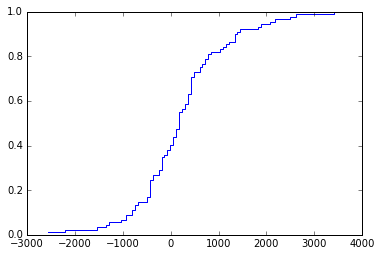

In [46]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

sample = allbetas[subj][10,:]
ecdf = sm.distributions.ECDF(sample)

x = np.linspace(min(sample), max(sample),num=100)
y = ecdf(x)
plt.step(x, y)

#### Run actual code/cross-validations

#### Run FDR correction for each test

In [59]:
qmat = {}
mvpa_mask = {}

ttest = {}
ttest = np.zeros((jointbetas.shape[0],2)) # raw t-vals and thresholded t-vals
ps = np.zeros((jointbetas.shape[0],))
# Only include SMN vertices
rois = np.where(networkdef==networkmappings['smn'])[0]
roi_ind = []
for roi in rois:
    roi_ind.extend(np.where(glasser==roi)[0])
roi_ind = np.reshape(np.asarray(roi_ind),-1)

# Run t-test
for v in roi_ind:
    t, ps[v] = stats.ttest_rel(jointbetas[v,:,0],jointbetas[v,:,1])
    ttest[v,0] = t

# Run FDR-correction
h0, q = mc.fdrcorrection0(ps[roi_ind])
ttest[roi_ind,1] = np.multiply(ttest[roi_ind,0],ps[roi_ind]<.05)


In [61]:
basedir = '/projects3/StroopActFlow/data/results/glm_ruleStimBetaSeries/motorResponse_localizer/'
# for subj in subjNums:

filename_mvpa = basedir + 'joint_motorResponse_ttest_LeftVRight_v3'

np.savetxt(filename_mvpa + '.csv', ttest, delimiter=',')
convertCSVToCIFTI64k(filename_mvpa+'.csv', filename_mvpa+'.dscalar.nii')


In [23]:
qmat = {}
mvpa_mask = {}

ttest = {}
for subj in subjNums:
    ttest[subj] = np.zeros((beta_dict[subj].shape[0],2)) # raw t-vals and thresholded t-vals
    ps = np.zeros((beta_dict[subj].shape[0],))
    # Only include SMN vertices
    rois = np.where(networkdef==networkmappings['smn'])[0]
    roi_ind = []
    for roi in rois:
        roi_ind.extend(np.where(glasser==roi)[0])
    roi_ind = np.reshape(np.asarray(roi_ind),-1)
    
    # Run t-test
    for v in roi_ind:
        t, ps[v] = stats.ttest_rel(beta_dict[subj][v,:,0],beta_dict[subj][v,:,1])
        ttest[subj][v,0] = t
        
    # Run FDR-correction
    h0, q = mc.fdrcorrection0(ps[roi_ind])
    ttest[subj][roi_ind,1] = np.multiply(ttest[subj][roi_ind,0],ps[roi_ind]<.05)


### 2.2 Save MVPA maps to CSV and dscalar files

In [26]:
basedir = '/projects3/StroopActFlow/data/results/glm_ruleStimBetaSeries/motorResponse_localizer/'
for subj in subjNums:
    
    filename_mvpa = basedir + subj + '_motorResponse_ttest_LeftVRight_v3'
        
    np.savetxt(filename_mvpa + '.csv', ttest[subj], delimiter=',')
    convertCSVToCIFTI64k(filename_mvpa+'.csv', filename_mvpa+'.dscalar.nii')
